In [12]:
from hyp_solver3 import HypProblem, Mesh, Solver, solve_oc
import matplotlib.pyplot as plt
import numpy as np
import scipy
from time import time
import json

In [13]:
G11_true = lambda t: - 4*np.cos(t) / (np.cos(t)-4*np.sin(t))
G22_true = lambda t: - (np.sin(t)) / (np.cos(t) - 4* np.sin(t))

x0 = lambda s: 0
y0 = lambda s: (3*s+1)/(2*(s+1))

x_an = lambda s, t: 2*(s**2+1)*np.sin(t)
y_an = lambda s, t: (3*s+1)/(2*(s+1))*np.cos(t)
T = [0, 0.2]
S = [0, 1]
C = [1,2]
# C = [2.3,0.9]

B11 = lambda s, t: -2*s
B12 = lambda s, t: 4/3*s**2
B21 = lambda s, t: - (3*s+1)/(4*(s**2+1)*(s+1))
B22 = lambda s, t: 4/((s+1)*(3*s+1))

G11 = lambda t: - 4*np.cos(t) / (np.cos(t)-4*np.sin(t))
G12 = lambda t: - G11(t)
G21_ = lambda t: (np.sin(t)) / (np.cos(t) - 4* np.sin(t))
G21 = lambda t: G21_(t) - 1
G22 = lambda t: - G21(t)

F1 = lambda s, t: 4*s**3*np.sin(t)+2*np.cos(t)+4*s**2*np.cos(t)/(3*(s+1))
F2 = lambda s, t: 0

phi_dx = lambda s, x, y : -2*(x - x_an(s, T[1])) 
phi_dy = lambda s, x, y : -2*(y - y_an(s, T[1]))

hyp_problem = HypProblem(T=T, S=S, C=C, B=[[B11, B12], [B21, B22]], 
                         F=[F1, F2], G=[[G11, G12], [G21, G22]], 
                         X0=x0, Y0=y0, phi_dx=phi_dx, phi_dy=phi_dy)

mesh = Mesh(hyp_problem, 100)
solver = Solver()
solver.solve_initial(mesh, hyp_problem)
solver.solver_center(mesh, hyp_problem)
solver.solver_final(mesh, hyp_problem)


In [3]:
def save_rez(oc_problem, filename, times):
    rez = {}
    nodes = oc_problem.mesh.get_border(type_border="final", sort_s=True)
    s = [node[0][2] for node in nodes]
    xs = [node[1][0][0] for node in nodes]
    ys = [node[1][0][1] for node in nodes]
    xs_an = [x_an(si,T[1]) for si in s]
    ys_an = [y_an(si,T[1]) for si in s]
    deltas_x = np.array([abs(xi-xj) for xj, xi in zip(xs_an, xs)])
    deltas_y = np.array([abs(yi-yj) for yj, yi in zip(ys_an, ys)])
    
    nodes = mesh.get_border(type_border="left", sort_t=True)
    t = [node[0][3] for node in nodes]
    xt = [node[1][0][0] for node in nodes]
    yt = [node[1][0][1] for node in nodes]
    xt_an = [x_an(S[0], ti) for ti in t]
    yt_an = [y_an(S[0], ti) for ti in t]
    
    v_an = [G22_true(ti) for ti in t]
    v = [oc_problem.hyp_problem.G22(ti) for ti in t]
    
    deltas_v = np.array([abs(vi-v_ani) for vi, v_ani in zip(v, v_an)])
    rez = {
        "max dx": np.max(deltas_x),
        "max dy": np.max(deltas_y),
        "max dv": np.max(deltas_v),
        "int dx^2 ds": scipy.integrate.trapezoid(deltas_x**2, s),
        "int dy^2 ds": scipy.integrate.trapezoid(deltas_y**2, s),
        "int dv^2 dt": scipy.integrate.trapezoid(deltas_v**2, t),
        "t": t,
        "s": s,
        "xs": xs,
        "ys": ys,
        "xs_an": xs_an,
        "ys_an": ys_an,
        "xt": xt,
        "yt": yt,
        "xt_an": xt_an,
        "yt_an": yt_an,
        "v": v,
        "v_an": v_an,
        "time": times,
        "iter_solv": oc_problem.iteration_solv,
        "iter_conj_solv": oc_problem.iteration_conj_solv,
    }
    with open(filename, "w") as f:
        json.dump(rez, f)
    return rez

In [4]:
def plot_sys(mesh):
    plt.figure(figsize=(12,6))
    
    nodes = mesh.get_border(type_border="final", sort_s=True)
    s = [node[0][2] for node in nodes]
    x = [node[1][0][0] for node in nodes]
    y = [node[1][0][1] for node in nodes]
    
    plt.subplot(3, 2, 1)
    plt.plot(s, x, "ro")
    plt.plot(s, [x_an(si, T[1]) for si in s], "b-")
    plt.ylabel("x")
    plt.grid()
    plt.subplot(3, 2, 3)
    plt.plot(s, y, "ro")
    plt.plot(s, [y_an(si, T[1]) for si in s], "b-")
    plt.ylabel("y")
    plt.xlabel("s")
    plt.grid()

    deltas_x = [abs(xi-x_an(si,T[1])) for si, xi in zip(s, x)]
    deltas_y = [abs(yi-y_an(si,T[1])) for si, yi in zip(s, y)]

    
        
    print(f"t=t1:\n\tdx:{np.max(deltas_x)}\n\tdy:{np.max(deltas_y)}")

    nodes = mesh.get_border(type_border="left", sort_t=True)
    t = [node[0][3] for node in nodes]
    x = [node[1][0][0] for node in nodes]
    y = [node[1][0][1] for node in nodes]
    plt.subplot(3, 2, 2)
    plt.plot(t, x, "ro")
    plt.plot(t, [x_an(S[0], ti) for ti in t], "b-")
    plt.grid()
    plt.legend(["x", "x_an"])
    plt.subplot(3, 2, 4)
    plt.plot(t, y, "ro")
    plt.plot(t, [y_an(S[0], ti) for ti in t], "b-")
    plt.legend(["y", "y_an"])
    plt.grid()

    deltas_x = [abs(xi-x_an(S[0],ti)) for ti, xi in zip(t, x)]
    deltas_y = [abs(yi-y_an(S[0],ti)) for ti, yi in zip(t, y)]
        
    print(f"s=s0:\n\tdx:{np.max(deltas_x)} \n\tdy:{np.max(deltas_y)}")

    
    nodes = mesh.get_border(type_border="left", sort_t=True)
    t = [node[0][3] for node in nodes]
    v_true = [G22_true(ti) for ti in t]
    v = [hyp_problem.G22(ti) for ti in t]
    plt.subplot(3, 2, 6)
    plt.plot(t, v, "ro")
    plt.plot(t, v_true, "b-")
    plt.legend(["v", "v_an"])
    plt.ylabel("v")
    plt.xlabel("t")
    plt.grid()

In [5]:
def print_table(name_exp):
    times = []
    iter1 = []
    iter2 = []
    row_dsx = []
    row_dsy = []
    row_dtv = []
    row_intxds = []
    row_intyds = []
    row_intvdt = []
    for type_oc in ["mpm", "cgm", "impm"]:
        filename = name_exp +"_"+ type_oc + ".json"
        with open(filename, "r") as f:
            js = json.load(f)
            times.append(js["time"])
            iter1.append(js["iter_solv"])
            iter2 .append(js["iter_conj_solv"])
            row_dsx.append(js["max dx"])
            row_dsy.append(js["max dy"])
            row_dtv.append(js["max dv"])
            row_intxds.append(js["int dx^2 ds"])
            row_intyds.append(js["int dy^2 ds"])
            row_intvdt.append(js["int dv^2 dt"])


    latex_text = fr"""
\begin{{tabular}}[h]{{|c||c | c | c|}} 
\hline
method & MPM & GCM & IMPM \\ [0.5ex] 
\hline\hline
times (sec)& {times[0]:.1f} & {times[1]:.1f} & {times[2]:.1f} \\ 
iter & {iter1[0]} & {iter1[1]} & {iter1[2]} \\
conj iter& {iter2[0]} & {iter2[1]} & {iter2[2]} \\
\hline
$\max |\Delta_{{t_1}}x|$ & {row_dsx[0]:.1e} & {row_dsx[1]:.1e} & {row_dsx[2]:.1e}  \\
$\max |\Delta_{{t_1}}y|$ & {row_dsy[0]:.1e} & {row_dsy[1]:.1e} & {row_dsy[2]:.1e}  \\
$\int_S (\Delta_{{t_1}}x)^2 ds$ & {row_intxds[0]:.1e} & {row_intxds[1]:.1e} & {row_intxds[2]:.1e}  \\
$\int_S (\Delta_{{t_1}}y)^2 ds$ & {row_intyds[0]:.1e} & {row_intyds[1]:.1e} & {row_intyds[2]:.1e}  \\
\hline
$\max |\Delta_{{s_0}} v|$ & {row_dtv[0]:.1e} & {row_dtv[1]:.1e} & {row_dtv[2]:.1e}  \\
$\int_T (\Delta_{{s_0}}v)^2 dt$ & {row_intvdt[0]:.1e} & {row_intvdt[1]:.1e} & {row_intvdt[2]:.1e}  \\
\hline
\end{{tabular}}
    """
    print(latex_text)

In [6]:
def exp(name_exp, U0, eps=0.00001):
    EPS = eps
    ULIM = [-2.5, 1]
    # Первое приближение ===============================================
    # uk_0 = np.random.random(len(t_h))
    G22_0 = U0
    # G22_0 = lambda t: G22_true(t)
    G21_0 = lambda t:  - G22_0(t)
    hyp_problem.set_G([[G11, G12], [G21_0, G22_0]])
    
    solver.solve_initial(mesh, hyp_problem)
    solver.solver_center(mesh, hyp_problem)
    solver.solver_final(mesh, hyp_problem)
    plot_sys(mesh)

    for type_oc in ["mpm", "cgm", "impm"]:
        U0 = G22_0
        xs = lambda s: x_an(s, T[1])
        ys = lambda s: y_an(s, T[1])
        start_time = time()
        rez_oc = solve_oc(hyp_problem, mesh, U0, xs, ys, u_lim=ULIM, eps=EPS, debug=False, method=type_oc, beta = 0.0, delta = 1.0, eps_count_max=6) 
        rez_mpm = save_rez(rez_oc,  name_exp +"_"+ type_oc + ".json",time()-start_time) 

    print_table(name_exp)
    

In [64]:
def save_image_exp(name_exp, fun):    
    nodes = mesh.get_border(type_border="left", sort_t=True)
    t = np.array([node[0][3] for node in nodes])
    
    rez = {"mpm":{}, "cgm":{}, "impm":{}}
    for type_oc in rez.keys():
            filename = name_exp +"_"+ type_oc + ".json"
            with open(filename, "r") as f:
                rez[type_oc] = json.load(f)
    plt.plot(t , [fun(ti) for ti in t], "--")
    plt.plot(t , rez["mpm"]["v_an"], '')
    plt.plot(t , rez["mpm"]["v"], 'o:')
    plt.plot(t , rez["cgm"]["v"], 's:')
    plt.plot(t , rez["impm"]["v"], '*:')
    plt.grid()
    plt.legend(["$v_0$", "analytical", "MPM", "CGM", "IMPM"])
    plt.ylabel("$v(t)$")
    plt.xlabel("$t$")
    plt.savefig(f"{name_exp}.eps", format='eps')            

t=t1:
	dx:0.00013846054179433853
	dy:0.06704426898888038
s=s0:
	dx:3.216527706562111e-05 
	dy:0.06436294146277777


KeyboardInterrupt: 

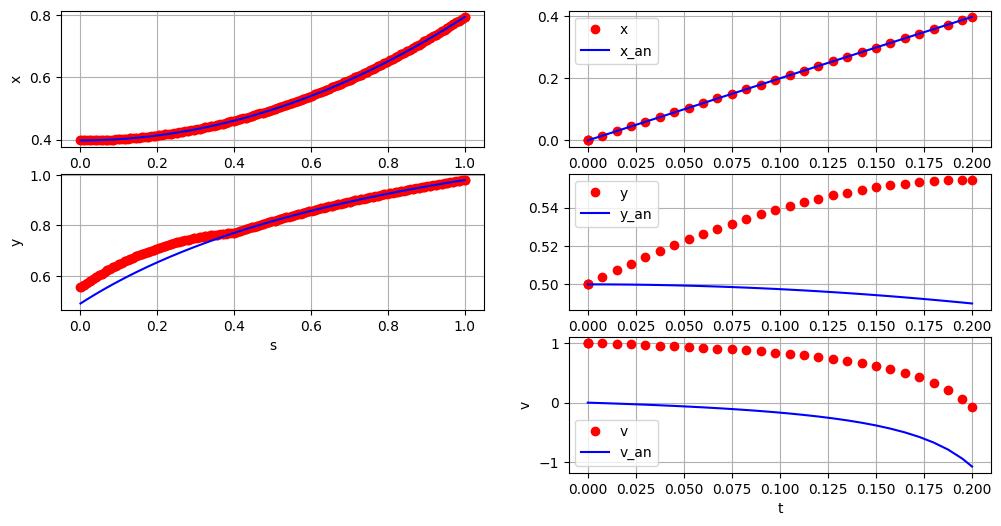

In [7]:
exp("plus1", lambda t: G22_true(t)+1, eps=0.00001)

In [ ]:
exp("step", lambda t: -1 if t < 0.1 else 1, eps=0.00001)

In [ ]:
exp("const", lambda t: 0, eps=0.00001)

In [ ]:
exp("times_sin50t", lambda t: G22_true(t)*np.sin(t*50), eps=0.00001)

In [11]:
# print_table("plus1")
# print_table("step")
# print_table("const")
print_table("times_sin50t")


\begin{tabular}[h]{|c||c | c | c|} 
\hline
method & MPM & GCM & IMPM \\ [0.5ex] 
\hline\hline
times (sec)& 4.5 & 50.4 & 391.2 \\ 
iter & 32 & 342 & 2805 \\
conj iter& 0 & 19 & 19 \\
\hline
$\max |\Delta_{t_1}x|$ & 9.3e-06 & 7.9e-06 & 7.8e-06  \\
$\max |\Delta_{t_1}y|$ & 8.4e-03 & 4.6e-03 & 1.9e-03  \\
$\int_S (\Delta_{t_1}x)^2 ds$ & 2.3e-11 & 1.5e-11 & 2.1e-11  \\
$\int_S (\Delta_{t_1}y)^2 ds$ & 9.2e-06 & 4.8e-06 & 4.2e-07  \\
\hline
$\max |\Delta_{s_0} v|$ & 1.7e+00 & 1.7e+00 & 1.7e+00  \\
$\int_T (\Delta_{s_0}v)^2 dt$ & 2.7e-02 & 9.5e-03 & 1.5e-02  \\
\hline
\end{tabular}
    


5763

array([[-1.50e+01, -7.00e+01,  7.50e-02, -0.00e+00],
       [ 1.50e+01, -1.00e+01,  5.25e-01,  0.00e+00],
       [-1.80e+01, -7.60e+01,  3.00e-02,  0.00e+00],
       ...,
       [-2.70e+01, -1.40e+01,  2.95e-01,  2.00e-01],
       [-2.00e+01,  0.00e+00,  4.00e-01,  2.00e-01],
       [-2.60e+01, -1.20e+01,  3.10e-01,  2.00e-01]])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


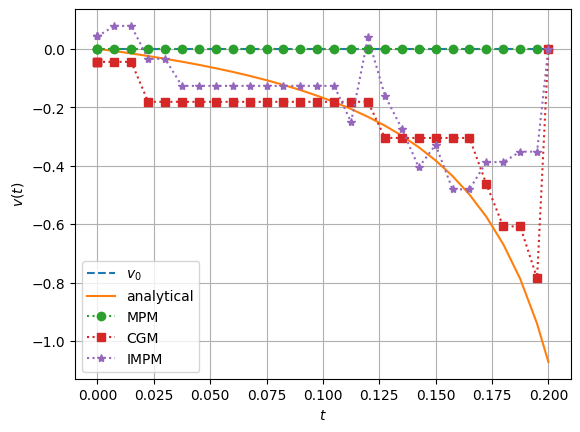

In [68]:
save_image_exp("const", lambda t: 0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


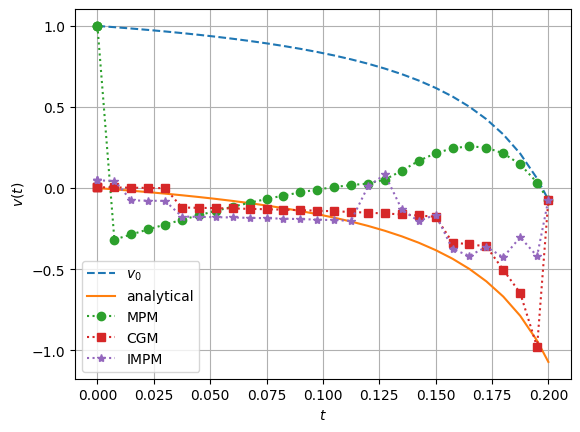

In [65]:
save_image_exp("plus1", lambda t: G22_true(t)+1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


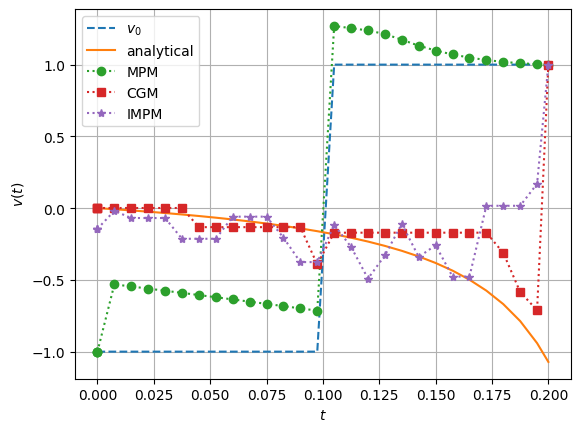

In [66]:
save_image_exp("step", lambda t: -1 if t < 0.1 else 1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


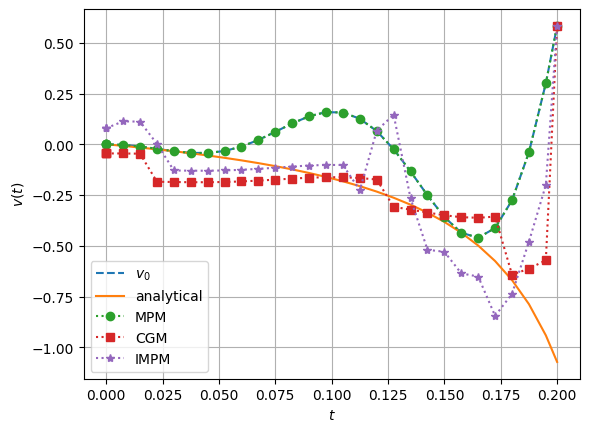

In [67]:
save_image_exp("times_sin50t", lambda t: G22_true(t)*np.sin(t*50))